In [57]:
import numpy as np
import pandas as pd
import os
import sys

# Add the directory containing the VotingModel to the Python path
sys.path.append(os.path.abspath('/Users/idrees/Code/govxs/'))
from model.VotingRules import mean_aggregation, median_aggregation, quadratic_aggregation

from model.VotingModel import VotingModel

def simulate_bribery_mean(model, target_project, desired_increase):
    num_voters, num_projects = model.voting_matrix.shape
    new_voting_matrix = model.voting_matrix.copy()

    # Calculate the original allocation
    original_allocation = model.mean_aggregation()
    original_funds = original_allocation[target_project]
 

    # Calculate the target allocation
    target_funds = original_funds + desired_increase
    total_required_votes = target_funds * num_voters
 

    # Calculate the current votes for the target project
    current_votes = np.sum(new_voting_matrix[:, target_project])

    votes_needed = total_required_votes - current_votes

    bribery_cost = votes_needed
    
    return bribery_cost

def simulate_bribery_quadratic(model, target_project, desired_increase):
    num_voters, num_projects = model.voting_matrix.shape
    new_voting_matrix = model.voting_matrix.copy()

    # Calculate the original allocation
    original_allocation = model.quadratic_aggregation()
    original_funds = original_allocation[target_project]

    # Calculate the target allocation
    target_funds = original_funds + desired_increase
    total_required_votes = (target_funds * np.sum(original_allocation)) ** 0.5

    # Calculate the current votes for the target project
    current_votes = np.sum(new_voting_matrix[:, target_project] ** 2)
    votes_needed = total_required_votes - np.sqrt(current_votes)
    votes_needed = votes_needed ** 2

    bribery_cost = votes_needed
       
    return bribery_cost

def simulate_bribery_median(model, target_project, desired_increase):
    num_voters, num_projects = model.voting_matrix.shape
    new_voting_matrix = model.voting_matrix.copy()
    original_voting_matrix=new_voting_matrix

    # Calculate the original allocation
    original_allocation = model.median_aggregation()
    original_funds = original_allocation[target_project]

    # Calculate the target allocation
    target_funds = original_funds + desired_increase

    # Calculate the current median vote for the target project
    votes = new_voting_matrix[:, target_project]
    current_median_vote = np.median(votes)

    # Determine the new median vote required
    total_required_votes = target_funds * model.num_voters / model.total_op_tokens
    votes_needed = total_required_votes - current_median_vote

    # Calculate the bribery cost as the amount needed to change the median vote
    bribery_cost = np.abs(votes_needed) * model.total_op_tokens / model.num_voters

    return bribery_cost


def evaluate_bribery_impact(model, target_project, desired_increase):
    # Bribery impact for each aggregation method
    bribery_costs = {}
    for method in ["mean", "median", "quadratic"]:
        if method == "mean":
            bribery_cost = simulate_bribery_mean(model, target_project, desired_increase)
        elif method == "median":
            bribery_cost = simulate_bribery_median(model, target_project, desired_increase)
        elif method == "quadratic":
            bribery_cost = simulate_bribery_quadratic(model, target_project, desired_increase)
    
        bribery_costs[method + "_bribery_cost"] = bribery_cost

    return bribery_costs# Initialize the model

In [72]:
def run_simulation(num_rounds, num_voters, num_projects, total_op_tokens, max_bribe,voter_type):
    results = []
    desired_increases = np.linspace(max_bribe/num_rounds, max_bribe, num_rounds)

    for i in range(num_rounds):
        # Initialize the model
        model = VotingModel(voter_type=voter_type,num_voters=num_voters, num_projects=num_projects, total_op_tokens=total_op_tokens)
        data=model.step()

        # Set parameters for bribery evaluation
        target_project = np.random.randint(0, num_projects)  # Randomly select a target project
        desired_increase = desired_increases[i] # Randomly set a desired increase between 5K and 10K OP tokens

        # Evaluate the impact of bribery
        bribery_costs = evaluate_bribery_impact(model, target_project, desired_increase)

        result = {
            "round": i + 1,
            "target_project": target_project,
            "desired_increase": desired_increase,
            "mean_bribery_cost": bribery_costs.get("mean_bribery_cost"),
            "median_bribery_cost": bribery_costs.get("median_bribery_cost"),
            "quadratic_bribery_cost": bribery_costs.get("quadratic_bribery_cost")
        }

        results.append(result)

    # Create a DataFrame from the results
    final_results = pd.DataFrame(results)
    return final_results

# Parameters for multiple simulations
num_rounds = 100
num_voters = 100
num_projects = 500
total_op_tokens = 30000
max_desired_fund_increase=1e6
voter_type='mallows_model'

# Run the simulations
final_results = run_simulation(num_rounds, num_voters, num_projects, total_op_tokens,max_desired_fund_increase,voter_type)

# Display the results
final_results

KeyboardInterrupt: 

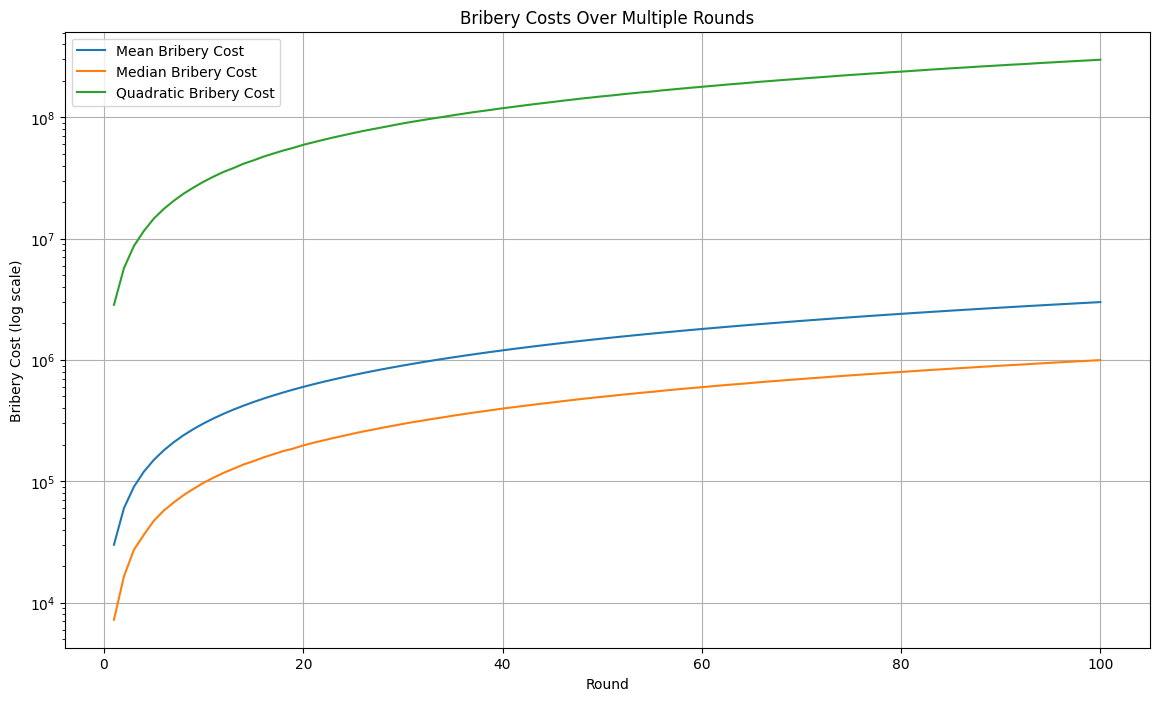

In [ ]:
import matplotlib.pyplot as plt

# Plot the results with a logarithmic y-axis
def plot_bribery_costs(df):
    plt.figure(figsize=(14, 8))

    # Plot mean bribery cost
    plt.plot(df['round'], df['mean_bribery_cost'], label='Mean Bribery Cost')

    # Plot median bribery cost
    plt.plot(df['round'], df['median_bribery_cost'], label='Median Bribery Cost')

    # Plot quadratic bribery cost
    plt.plot(df['round'], df['quadratic_bribery_cost'], label='Quadratic Bribery Cost')

    plt.xlabel('Round')
    plt.ylabel('Bribery Cost (log scale)')
    plt.yscale('log')
    plt.title('Bribery Costs Over Multiple Rounds')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot the bribery costs
plot_bribery_costs(final_results)

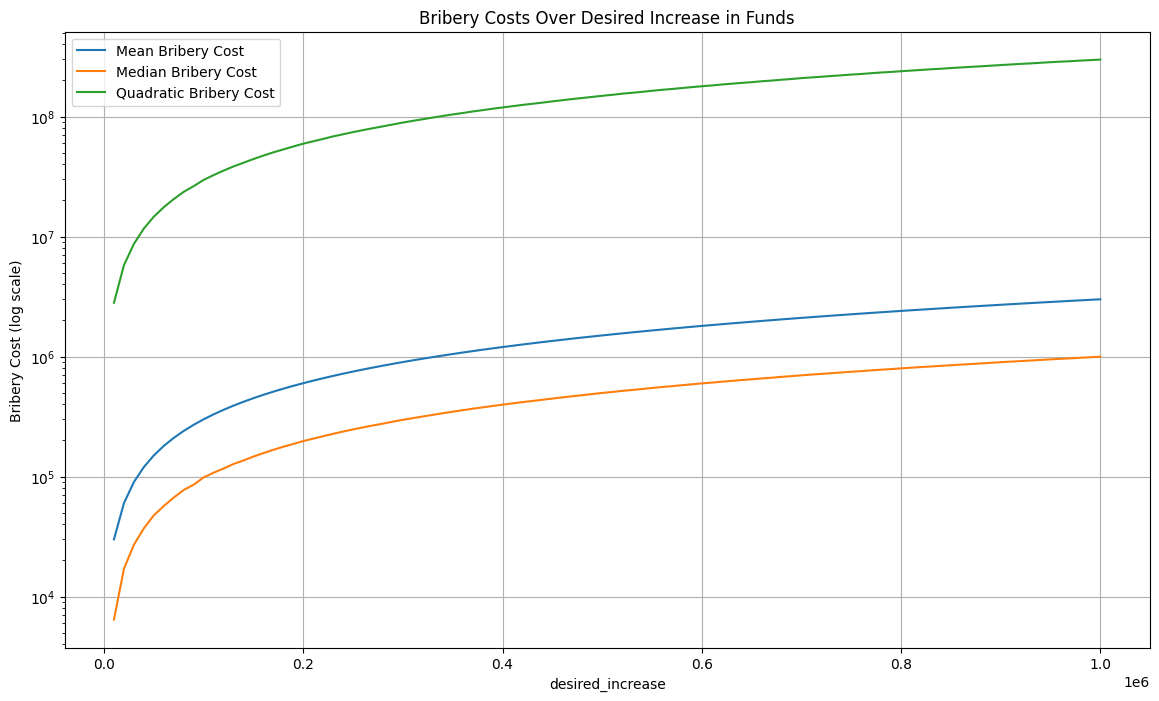

In [ ]:
def plot_bribery_costs(df):
    plt.figure(figsize=(14, 8))

    # Plot mean bribery cost
    plt.plot(df['desired_increase'], df['mean_bribery_cost'], label='Mean Bribery Cost')

    # Plot median bribery cost
    plt.plot(df['desired_increase'], df['median_bribery_cost'], label='Median Bribery Cost')

    # Plot quadratic bribery cost
    plt.plot(df['desired_increase'], df['quadratic_bribery_cost'], label='Quadratic Bribery Cost')

    plt.xlabel('desired_increase')
    plt.ylabel('Bribery Cost (log scale)')
    plt.yscale('log')
    plt.title('Bribery Costs Over Desired Increase in Funds')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot the bribery costs
plot_bribery_costs(final_results)

In [ ]:
summary_stats = final_results[['mean_bribery_cost', 'median_bribery_cost', 'quadratic_bribery_cost']].describe()
print(summary_stats)

       mean_bribery_cost  median_bribery_cost  quadratic_bribery_cost
count       1.000000e+02           100.000000            1.000000e+02
mean        1.515000e+06        502032.969710            1.502861e+08
std         8.703448e+05        290122.430662            8.660890e+07
min         3.000000e+04          6435.526316            2.807160e+06
25%         7.725000e+05        254579.668449            7.632691e+07
50%         1.515000e+06        502129.372689            1.501557e+08
75%         2.257500e+06        749430.527606            2.242152e+08
max         3.000000e+06        997129.096990            2.980783e+08


In [ ]:
from scipy import stats

mean_costs = final_results['mean_bribery_cost']
median_costs = final_results['median_bribery_cost']
quadratic_costs = final_results['quadratic_bribery_cost']

# Perform paired t-tests
t_test_mean_median = stats.ttest_rel(mean_costs, median_costs)
t_test_mean_quadratic = stats.ttest_rel(mean_costs, quadratic_costs)
t_test_median_quadratic = stats.ttest_rel(median_costs, quadratic_costs)

print("Paired t-test between Mean and Median Bribery Costs:", t_test_mean_median)
print("Paired t-test between Mean and Quadratic Bribery Costs:", t_test_mean_quadratic)
print("Paired t-test between Median and Quadratic Bribery Costs:", t_test_median_quadratic)


Paired t-test between Mean and Median Bribery Costs: TtestResult(statistic=np.float64(17.458240473845507), pvalue=np.float64(5.520147772057342e-32), df=np.int64(99))
Paired t-test between Mean and Quadratic Bribery Costs: TtestResult(statistic=np.float64(-17.35171004552058), pvalue=np.float64(8.728299329767999e-32), df=np.int64(99))
Paired t-test between Median and Quadratic Bribery Costs: TtestResult(statistic=np.float64(-17.352426520202613), pvalue=np.float64(8.701403351227592e-32), df=np.int64(99))


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_bribery_costs(final_results):
    fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

    sns.boxplot(x='voter_type', y='mean_bribery_cost', data=final_results, ax=axes[0])
    axes[0].set_title('Mean Bribery Cost')
    axes[0].set_xlabel('Voter Type')
    axes[0].set_ylabel('Bribery Cost')

    sns.boxplot(x='voter_type', y='median_bribery_cost', data=final_results, ax=axes[1])
    axes[1].set_title('Median Bribery Cost')
    axes[1].set_xlabel('Voter Type')
    axes[1].set_ylabel('')

    sns.boxplot(x='voter_type', y='quadratic_bribery_cost', data=final_results, ax=axes[2])
    axes[2].set_title('Quadratic Bribery Cost')
    axes[2].set_xlabel('Voter Type')
    axes[2].set_ylabel('')

    plt.tight_layout()
    plt.show()

plot_bribery_costs(final_results)
